In [141]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [142]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902280286, -0.00509552006, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592138022, -0.0166167412, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801395, 0.0339813568, -0.0206426941, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566836, 0.0381274521, -0.00846857857, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.033026401, -0.00849775691, 0.00957154203, -..."


In [143]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Can use dot product or cosine similarity if outputs of model aren't normalized. If using dot product make sure that the outputs are normalized.

In [144]:
query = "macronutrient functions"
print(f"Query: {query}")

#always embed query with the same embedding model as your data 
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

#top-k 
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrient functions
Time take to get scores on 1680 embeddings: 0.00047 seconds.


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6517, 0.6493, 0.6478]),
indices=tensor([42, 47, 46, 51, 41]))

In [145]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.01366 seconds.


In [146]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [147]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrient functions'

Results:
Score: 0.6843
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are m

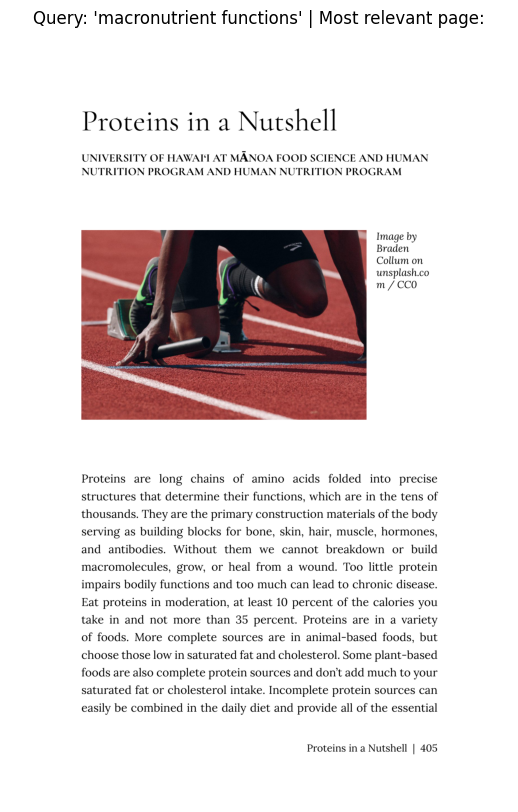

In [148]:
#display page that is being referenced
import fitz

pdf_path = "human-nutrition-text.pdf" 
doc = fitz.open(pdf_path)
page = doc.load_page(41 + 405) #replace with page number above

img = page.get_pixmap(dpi=300)

doc.close()

img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') 
plt.show()

In [149]:
#functions to use in final .py file
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5, #experiment
                                print_time: bool=True):

    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    dot_scores = util.dot_score(query_embedding, embeddings)[0]


    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [150]:
query = "What is the importance of eating protein"

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

(tensor([0.6308, 0.6264, 0.6225, 0.6213, 0.6170]),
 tensor([601, 593, 547, 585, 616]))

In [151]:
#Save all these functions to a .py file to run on Ai server
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

Query: What is the importance of eating protein

Results:
Score: 0.6308
Image by Braden Collum on unsplash.co m / CC0 Proteins in a Nutshell UNIVERSITY
OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION
PROGRAM  Proteins are long chains of amino acids folded into precise structures
that determine their functions, which are in the tens of thousands. They are the
primary construction materials of the body serving as building blocks for bone,
skin, hair, muscle, hormones, and antibodies. Without them we cannot breakdown
or build macromolecules, grow, or heal from a wound. Too little protein impairs
bodily functions and too much can lead to chronic disease. Eat proteins in
moderation, at least 10 percent of the calories you take in and not more than 35
percent. Proteins are in a variety of foods. More complete sources are in
animal-based foods, but choose those low in saturated fat and cholesterol. Some
plant-based foods are also complete protein sources and d

In [152]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")

config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_id)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 config=config,
                                                 torch_dtype=torch.float16,  
                                                 low_cpu_mem_usage=False)

llm_model.to("cpu")


[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [153]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, 
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [154]:
#tokenize query
input_tokens = tokenizer(input_text, return_tensors='pt')
print(f"[INFO] Tokenized input: {input_tokens}")

#generate outputs
with torch.no_grad(): 
    generated_tokens = llm_model.generate(**input_tokens, max_length=250) 


[INFO] Tokenized input: {'input_ids': tensor([[     2,   1841,    708,    573, 186809, 184592, 235269,    578,   1212,
          16065,    749,    984,   1554,    575,    573,   3515,   2971, 235336]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [155]:
#decode tokens to text
output_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
print(f"Generated output: {output_text}")

Generated output: What are the macronutrients, and what roles do they play in the human body?

Sure, here's a summary of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:** Provide energy for the body's cells and tissues. They are the primary source of fuel for most physical activity.
* **Protein:** Builds and repairs tissues, enzymes, and hormones. It also helps regulate blood sugar levels and immune function.
* **Fat:** Provides energy, insulation, and the hormone called leptin, which helps regulate hunger and satiety.

**Micronutrients:**

* **Vitamin B12:** Essential for red blood cell production.
* **Vitamin D:** Helps the body absorb calcium and phosphorus.
* **Vitamin C:** Supports the immune system and collagen production.
* **Folate:** Important for cell growth and development.
* **Iron:** Essential for red blood cell production.
* **Magnesium:** Involved in muscle and nerve function.
* **Zinc:** Supports immune function and wound h

In [156]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as in-depth as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is a healthy breakfast option?
Answer: A healthy breakfast is one that provides a good balance of macronutrients (carbohydrates, proteins, and fats), essential vitamins and minerals, and fiber, which together help sustain energy levels, support metabolism, and promote overall well-being. One example of this is oatmeal topped with berries, a spoonful of almond butter, and a side of Greek yogurt.
\nExample 2:
Query: What are the causes of type 2 diabetes and how can prevent it?
Answer: Type 2 diabetes is primarily caused by a combination of genetic factors and lifestyle choices, such as obesity, lack of physical activity, poor diet, and insulin resistance. It can be prevented by maintaining a healthy weight, eating a balanced diet rich in whole foods, staying physically active, managing stress, and avoiding excessive consumption of sugary and processed foods.
\nExample 3:
Query: What foods should I look at if I want to lose weight and improve heart health?
Answer: Focus on whole foods like vegetables, fruits, whole grains, lean proteins (such as fish, chicken, and legumes), and healthy fats (like avocados, nuts, and olive oil). Also, include foods high in fiber, like oats and leafy greens, and limit processed foods, sugary snacks, and saturated fats to support weight loss and heart health.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context, query=query)
    dialogue_template = [{"role": "user", "content": base_prompt}]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)
    return prompt

In [157]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True, 
                             max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What is the importance of eating protein
RAG answer:
<bos>Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients** are nutrients that the body needs in large amounts for proper functioning. They are divided into four categories:

1. **Carbohydrates:**
   - Provide energy for the body's cells and tissues.
   - Carbohydrates are the primary fuel for most of the body's cells.
   - Sources: bread, pasta, rice, potatoes, oats, fruits, and vegetables.

2. **Proteins:**
   - Build and repair tissues, enzymes, hormones, and antibodies.
   - Proteins are essential for muscle growth, tissue repair, and enzyme production.
   - Sources: meat, fish, poultry, legumes, nuts, and seeds.

3. **Fats:**
   - Provide energy, insulation, and help absorb fat-soluble vitamins.
   - Fat is essential for hormone production, cell signaling, and the absorption of fat-soluble vitamins (A, D, E, and K).
   - Sources: butter, oil, nuts, seeds, and some plant-based

In [158]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() 
        
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    input_ids = tokenizer(prompt, return_tensors="pt").to("cpu")

    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [159]:
query = "What is the importance of eating protein?"
print(f"Query: {query}")

answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What is the importance of eating protein?
Answer:

The passage does not explicitly mention the importance of eating protein, so I
cannot answer this question from the provided context.
Context items:


[{'page_number': 405,
  'sentence_chunk': 'Image by Braden Collum on unsplash.co m / CC0 Proteins in a Nutshell UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Proteins are long chains of amino acids folded into precise structures that determine their functions, which are in the tens of thousands. They are the primary construction materials of the body serving as building blocks for bone, skin, hair, muscle, hormones, and antibodies. Without them we cannot breakdown or build macromolecules, grow, or heal from a wound. Too little protein impairs bodily functions and too much can lead to chronic disease. Eat proteins in moderation, at least 10 percent of the calories you take in and not more than 35 percent. Proteins are in a variety of foods. More complete sources are in animal-based foods, but choose those low in saturated fat and cholesterol. Some plant-based foods are also complete protein sources and don’t add much to your saturat